<a href="https://colab.research.google.com/github/boshuaiYu/CaiCai_DL/blob/main/CaiCai_DL_week3.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

<font color="red">梯度方向总是比loss()函数少一维

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

In [ ]:
w1 = np.arange(-10,10,0.05)
w2 = np.arange(-10,10,0.05)
w1, w2 = np.meshgrid(w1, w2)
lossfn = (2 - w1 - w2)**2 + (4 - 3*w1 - w2)**2
#定义一个绘制三维图像的函数
#elev表示上下旋转的角度
#azim表示平行旋转的角度
def plot_3D(elev=45,azim=60,X=w1,y=w2):
  fig, ax = plt.subplots(1, 1,constrained_layout=True, figsize=(8, 8))
  ax = plt.subplot(projection="3d")
  ax.plot_surface(w1, w2, lossfn, cmap='rainbow',alpha=0.7)
  ax.view_init(elev=elev,azim=azim)
  ax.set_xlabel("w1",fontsize=20)
  ax.set_ylabel("w2",fontsize=20)
  ax.set_zlabel("Lossfn",fontsize=20)
  plt.show()
from ipywidgets import interact,fixed
interact(plot_3D,elev=[0,15,30],azip=(-180,180),X=fixed(w1),y=fixed(w2))
plt.show()

interactive(children=(Dropdown(description='elev', options=(0, 15, 30), value=0), IntSlider(value=60, descript…

**Pytorch实现反向传播**

In [ ]:
import torch
import torch.nn as nn

In [ ]:
torch.random.manual_seed(420)
X = torch.rand((500,20),dtype=torch.float32)*100
y = torch.randint(low=0,high=3,size=(500,),dtype=torch.float32)

In [ ]:
class Model(nn.Module):
  def __init__(self,in_features,out_features):
    super(Model,self).__init__()
    self.Linear1 = nn.Linear(in_features,13,bias=True)
    self.Linear2 = nn.Linear(13,8,bias=True)
    self.output = nn.Linear(8,out_features,bias=True)
  
  def forward(self,x):
    z1 = self.Linear1(x)
    sigma1 = torch.relu(z1)
    z2 = self.Linear2(sigma1)
    sigma2 = torch.sigmoid(z2)
    output = self.output(sigma2)
    # 损失函数不用计算softmax
    return output



input_ = X.shape[1]
output_ = len(y.unique())

In [ ]:
torch.random.manual_seed(420)
net = Model(in_features=input_,out_features=output_)
zhat = net.forward(X)

In [ ]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()
loss = criterion(zhat,y.long())
loss

tensor(1.1057, grad_fn=<NllLossBackward0>)

In [ ]:
loss.backward(retain_graph=True)
net.Linear1.weight.grad.shape

torch.Size([13, 20])

**使用nn.Module继承后的类及进行正向传播时，权重是自动生成的，自动被设置为<font color="red">requires_grad=True**

In [ ]:
net

Model(
  (Linear1): Linear(in_features=20, out_features=13, bias=True)
  (Linear2): Linear(in_features=13, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)

**Momentum动量方法：让上一步的梯度向量与现在这一点的梯度向量以加权的方式求和，求解出受到上一步大小和方向影响的真实下降方向，再让坐标点向真实下降方向移动**

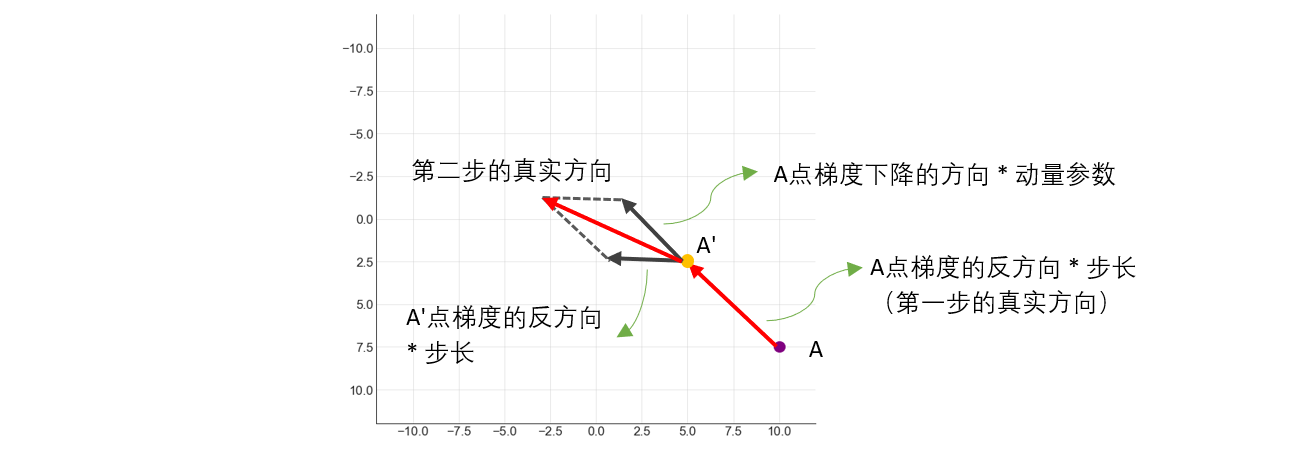

In [ ]:
# momentum
# v(t) = gamma * v(t-1) - lr*dw
# w(t+1) = v(t) + w(t)
lr = 0.1
gamma = 0.9
dw = net.Linear1.weight.grad
w = net.Linear1.weight.data

In [ ]:
v = torch.zeros(dw.shape[0],dw.shape[1])

In [ ]:
v = gamma * v -lr*dw
w += v
w

**torch.optim实现带动量的梯度下降**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# 超参数设定
lr = 0.1
gamma = 0.9

In [ ]:
class Model(nn.Module):
  def __init__(self,in_features,out_features):
    super(Model,self).__init__()
    self.Linear1 = nn.Linear(in_features,13,bias=True)
    self.Linear2 = nn.Linear(13,8,bias=True)
    self.output = nn.Linear(8,out_features,bias=True)
  
  def forward(self,x):
    z1 = self.Linear1(x)
    sigma1 = torch.relu(z1)
    z2 = self.Linear2(sigma1)
    sigma2 = torch.sigmoid(z2)
    output = self.output(sigma2)
    # 损失函数不用计算softmax
    return output



input_ = X.shape[1]
output_ = len(y.unique())

In [ ]:
# 实例化神经网络
torch.random.manual_seed(420)
net = Model(in_features=input_,out_features=output_)
net.parameters() # 一次性导出现有神经网络下的全部权重和截距

<generator object Module.parameters at 0x7fbc9bdc2ac0>

In [ ]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()

In [ ]:
# 定义优化算法
opt = optim.SGD(net.parameters() # 参数
        , lr=lr # 学习率
        , momentum=gamma # 衰减权数
        )

<font color="yellow"> 
1. 先正向传播，并计算正向传播下的损失函数
2. 反向传播，得到梯度
3. 更新权重和动量
4. 清除原来储存的梯度，为下一次计算梯度腾出空间

In [ ]:
zhat = net.forward(X) # 正向传播
loss = criterion(zhat,y.long()) # 计算损失函数
loss.backward() # 反向传播
opt.step() # 更新权重
opt.zero_grad() # 清空梯度
print(loss)
print(net.Linear1.weight.data[0][:10])

tensor(1.0792, grad_fn=<NllLossBackward0>)
tensor([ 0.1397, -0.1338,  0.2166, -0.1772, -0.0669, -0.1535,  0.1759,  0.0865,
        -0.1106, -0.1725])


**迭代：batch_size与epoches**

<font color="yellow">**epoch:表示算法将全部训练数据都使用一次**
 
 <font color="white">**batch：是每次选取训练样本中小样本的个数**

<font color="orange">**例：epoch=60表示让完整神经网络中数据训练60次**

<font color="orange">**batch=10表示全部数据分为了10份进行随机梯度下降**

**相当于完整的epoch60中，batch要循环10*60=600次**</font>


**TensorDataset和DataLoader**

**TensorDataset类似于打包的功能**

In [ ]:
import torch
from torch.utils.data import TensorDataset

In [ ]:
a = torch.randn(500,2,3) # 三维数据-类似于二维表格
b = torch.randn(500,3,4,5) # 四维数据-类似于图像
c = torch.randn(500,1) # 二维数据-类似于标签
# 被合并对象要求第一维度上的值相等

In [ ]:
for x in TensorDataset(a,b,c):
  print(x)
  break

(tensor([[-2.1745,  0.3281, -0.6057],
        [ 0.1785, -0.5733,  0.4262]]), tensor([[[-0.5317,  0.4563, -1.0927,  1.5642,  0.0179],
         [-1.3477, -1.4970, -0.2081,  0.1135, -0.5056],
         [-0.9127,  0.9290,  0.7286, -1.4086, -0.2180],
         [ 0.5779,  0.1757, -1.5832,  0.0394, -0.9174]],

        [[ 1.0788,  0.9541,  0.8184,  1.0539, -0.4588],
         [-1.0904,  0.1325, -0.7763,  1.1910,  1.6790],
         [-2.4798,  0.3649,  0.0547,  1.5869,  0.0226],
         [-0.5494, -0.7922, -1.4242,  1.5007, -1.8228]],

        [[ 0.9590, -0.3123,  0.9605, -0.7440, -1.5964],
         [ 2.5020, -0.9144, -1.1810,  2.4938,  0.0779],
         [-1.1216, -1.0008,  0.2901, -1.0058,  0.0275],
         [ 2.1900,  2.5902,  0.9958,  0.5398, -1.2321]]]), tensor([0.7715]))


**DataLoader-用来切割小批量的类**

In [ ]:
data = TensorDataset(b,c)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
for x in DataLoader(data):
  print(x)
  break

[tensor([[[[-0.5317,  0.4563, -1.0927,  1.5642,  0.0179],
          [-1.3477, -1.4970, -0.2081,  0.1135, -0.5056],
          [-0.9127,  0.9290,  0.7286, -1.4086, -0.2180],
          [ 0.5779,  0.1757, -1.5832,  0.0394, -0.9174]],

         [[ 1.0788,  0.9541,  0.8184,  1.0539, -0.4588],
          [-1.0904,  0.1325, -0.7763,  1.1910,  1.6790],
          [-2.4798,  0.3649,  0.0547,  1.5869,  0.0226],
          [-0.5494, -0.7922, -1.4242,  1.5007, -1.8228]],

         [[ 0.9590, -0.3123,  0.9605, -0.7440, -1.5964],
          [ 2.5020, -0.9144, -1.1810,  2.4938,  0.0779],
          [-1.1216, -1.0008,  0.2901, -1.0058,  0.0275],
          [ 2.1900,  2.5902,  0.9958,  0.5398, -1.2321]]]]), tensor([[0.7715]])]


In [ ]:
bs = 120 # batch_size大小

In [ ]:
dataset = DataLoader(
    data # 需要处理的数据
    ,batch_size=bs # 小批量处理的个数
    ,shuffle=True # 划分小批量前是否随机打乱数据
    ,drop_last=False # 是否舍弃最后一个不足一个batch_size的batch
    )

In [ ]:
for i in dataset:
  print(i[0].shape)

torch.Size([120, 3, 4, 5])
torch.Size([120, 3, 4, 5])
torch.Size([120, 3, 4, 5])
torch.Size([120, 3, 4, 5])
torch.Size([20, 3, 4, 5])


In [ ]:
len(dataset) # 返回一组完整数据中共有多少个batch

5

In [ ]:
len(dataset.dataset) # 返回样本的个数

500

**DataLoader本身不能索引，但DataLoader.dataset会返回数据**

In [ ]:
dataset.batch_size # 返回batch_size的大小

120